In [0]:
from keras.preprocessing.image import load_img, img_to_array

# [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

*There is large consent that successful training of deep networks requires many thousand annotated training samples. In this paper, we present a network and training strategy that relies on the strong use of data augmentation to use the available annotated samples more efficiently. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. We show that such a network can be trained end-to-end from very few images and outperforms the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks.* 

Olaf Ronneberger, Philipp Fischer, and Thomas Brox

## Primer: Fully Convolutional Networks (FCNs)

As we have seen, convolutional neural networks are especially effective for learning hierarchies of features in data with spatial dependencies (e.g., images, text, audio, etc.).  Whereas generic convolutional neural network models generally include one or more dense layers at the top of the network for prediction, fully convolutional networks utilize convolutional layers from end-to-end.

Given that the parameterization of a typical convolutional layer is not constrained by the dimension of the input Tensor (excluding the number of chanels in the input), fully convolutional networks enable inference on variable sized input.  A particular application in which this characteristic is extremely beneficial is in the task of pixel-wise semantic segmentation of images, in which each pixel in the input image is assigned a class.

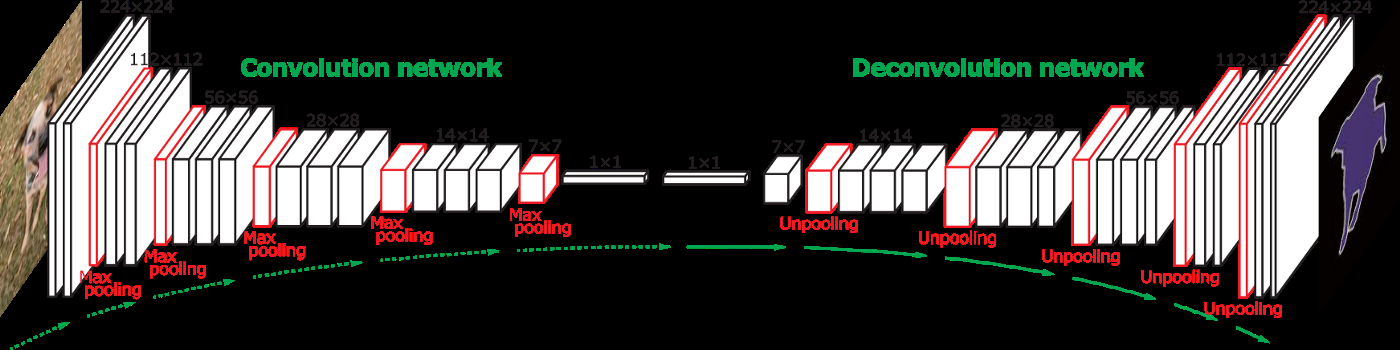

In [0]:
load_img('/content/drive/My Drive/EEG GAN/unet lecture/fcn_example.png')

Upsampling of the latent feature maps can be done with upsampling (e.g., bilinear interpolation, nearest neighbor upsampling, etc.) or a transpose convolution (also known as a deconvolution) with learnable parameters.  Transpose convolutions enable us to gradually increase the size of the latent tensors.  In pixel-wise image segmentation, this is often done until the tensor is the same size as the original input image.

Provided below is a depiction of upsampling a 2x2 tensor to a 3x3 tensors using a transpose convolution with a 2x2 kernel.

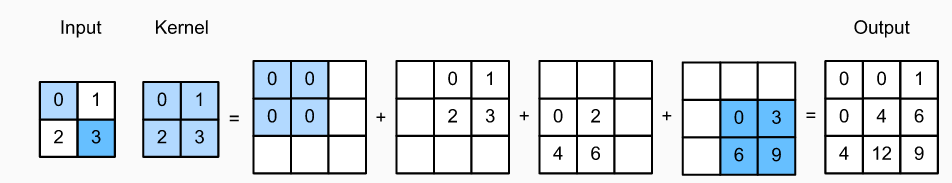

In [0]:
load_img('/content/drive/My Drive/EEG GAN/unet lecture/convT.png')

## U-Net: Convolutional Networks for Biomedical Image Segmentation

In *U-Net: Convolutional Networks for Biomedical Image Segmentation*, Ronneberger, Fischer, and Brox propose a network architecture and data augmentation techniques to efficiently train a fully convolutional network with relatively few training images.  Using the methods that they propose in this paper, state of the art results were achieved on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks, the PhC-U373 dataset, and the DIC-HeLa dataset (biomedical image segmentation datasets).  


### U-Net Network Architecture
Although this paper emphasized the effectiveness of their proposed network on biomedical image segmentation data sets with relatively few training examples, the U-Net architecture they propose has proven its efficacy in image segmentation tasks.  This network is claimed to perform well with small training sets and yield more detailed segmentation results over traditional fully convolutional networks. The specific architecture proposed is illustrated below.

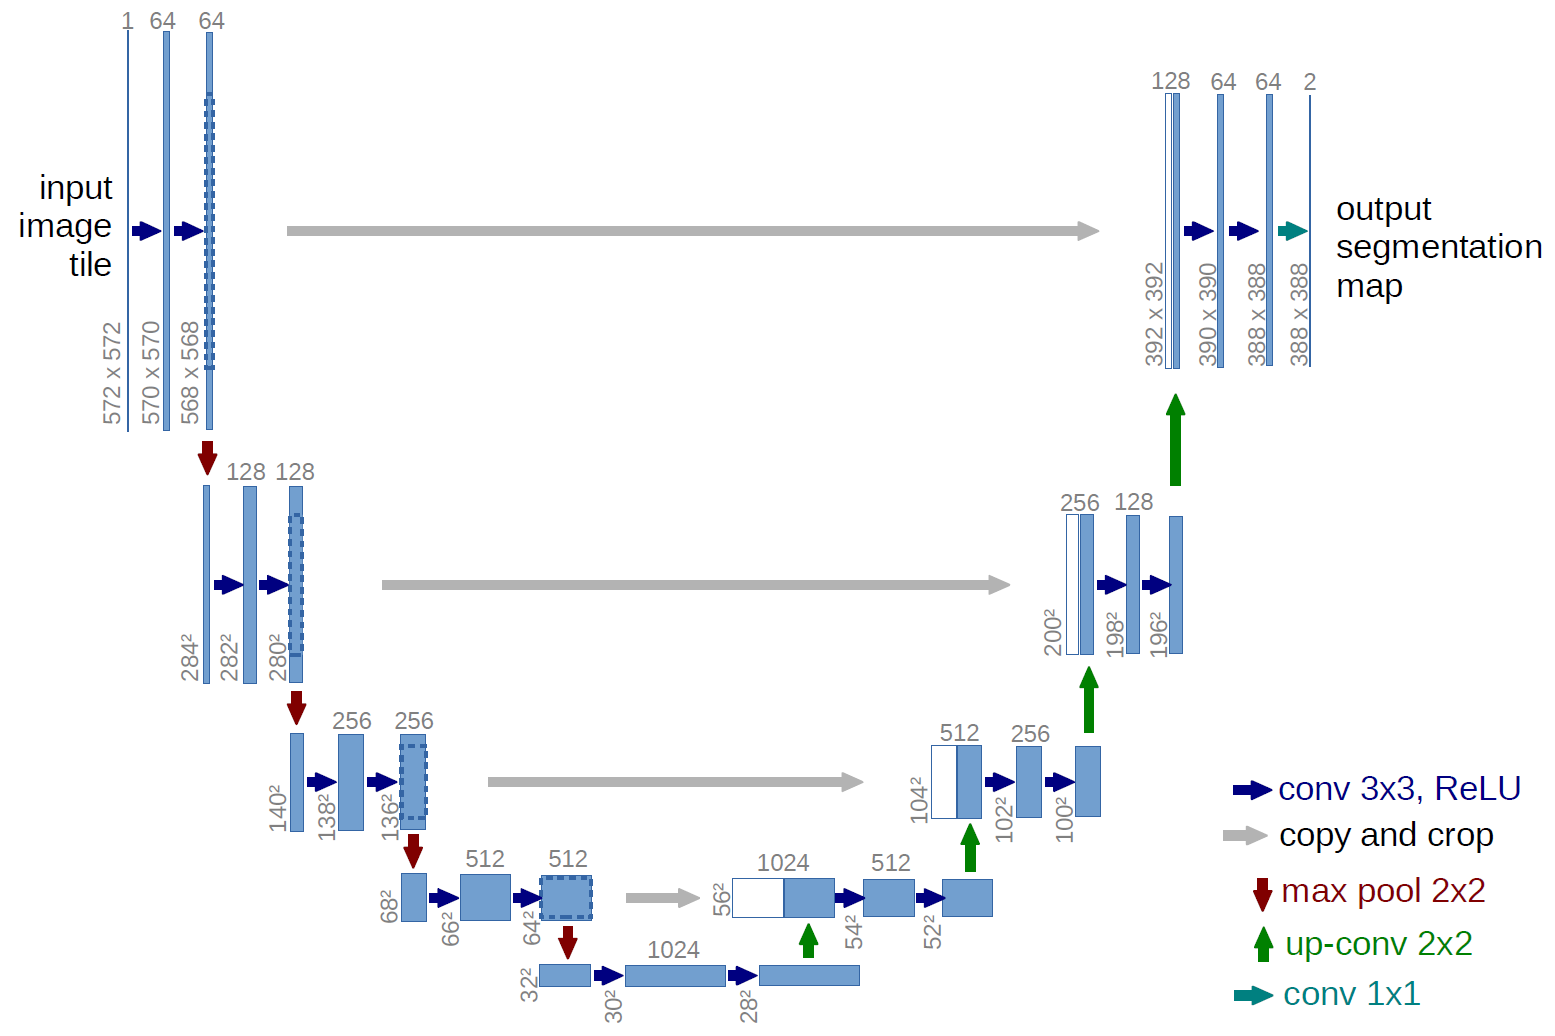

In [0]:
load_img('/content/drive/My Drive/EEG GAN/unet lecture/unet_img.png')

The unique aspect of the U-Net architecture over traditional fully convolutional networks is the concatenation and additional convolution that is done between feature maps from early and late stages in the network.  Since the feature maps output in the contracting portion of the network have greater resolution than those that are output by the upsampling layers, concatenating these two feature maps and applying a successive convolutional operation to the result enables more precise segmentation.  As an added benefit, these cross-network connections can also better enable the flow of gradients to early layers in the network.


### Data Augmentation Techniques
Annotated biomedical image datasets often have relatively few training instances.  The ISBI dataset, for example, contains only 30 annotated images.  For this reason (and other task specific reasons), data augmentation is often an important method in training a generalizable network.  The augmentations listed in this paper include random shifts, rotations, elastic deformations (via pixel displacement), and gray value variations.


### Training
Although the focal point of this presentation is the U-Net architecture, I believe it is worthwhile to inspect how training was performed on the on the biomedical segmentation image datasets described in this paper.  Training was performed by utilizing Stochastic Gradient Descent (with momentum) to minimize the loss function
$$E = \sum_{x \in \Omega} w(x) \log (p_{\ell(x)}(x))$$

where $\Omega$ is the set of pixel locations in the output map, $p_{\ell(x)}(x)$ denotes the softmax over the $k$ class outputs at pixel x, and $w(x)$ is a precomputed weight-map introduced so that the fine borders that separate neuronal structures are heavily weighted (this is important since objects often appear close together in the annotated segmentations).
$$w(x) = w_c(x) + w_0 \cdot \exp \left( - \frac{(d_1(x) + d_2(x))^2}{2\sigma^2}\right)$$

$$w_c(x) \text{ is a class weight map}$$

$$d_1(x) \text{ and } d_2(x) \text{ are the distances to the first and second closest cells, respectively}$$

$$w_0 = 10 \text{ pixels}$$
$$\sigma \approx 5 \text{ pixels}$$

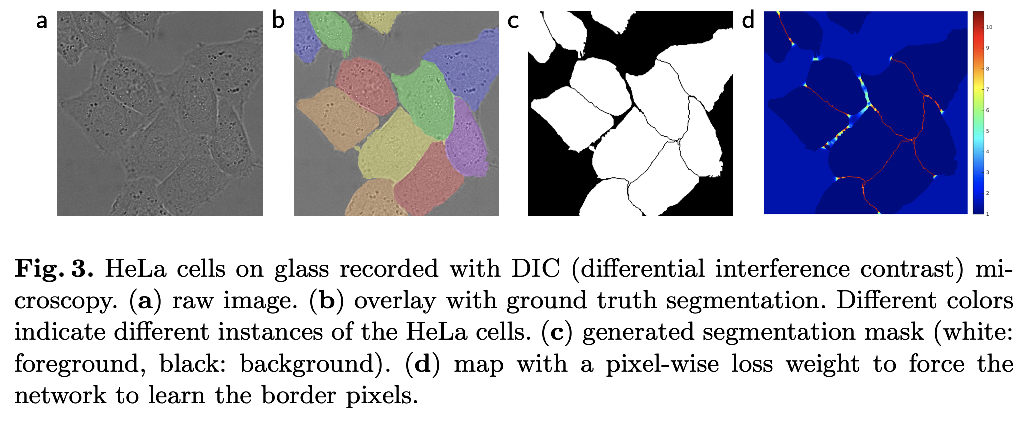

In [0]:
load_img('/content/drive/My Drive/EEG GAN/unet lecture/cell_border.png', target_size=(424,1032))

___
# U-Net Example in Keras

In [0]:
import numpy as np
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Conv2DTranspose, MaxPool2D, Input, Conv2D, Concatenate
from keras.models import Model, Sequential, load_model
from keras.activations import relu, sigmoid
from keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image
import cv2

%matplotlib inline

In [0]:
tf.random.set_seed(0)
np.random.seed(0)

### Dataset Overview

The data used in this notebook is from the [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge).  Each instance in the data set is an image of a car and its associated label is a binary mask image (of identical dimensions) that masks the vehicle from the background of the image.  In this notebook, a U-Net will be trained to learn how to output this mask given the original image as input.

In the code cells below, I provide a view of some of the training data images and masks as well as pre-process the data for use in the U-Net architecture implemented later in the notebook.  As this notebook is intended to exemplify the use of U-Nets as a viable network for image masking, only a subset of the Carvana dataset will be used and the images of this subset have been downsampled to 224x224.

In [0]:
# Loading Images and Masks and splitting the data into training, validation, and test sets
imgs = np.load('/content/drive/My Drive/EEG GAN/carvana data/caravana_numpy_arrays/X_1024.npy')
masks = np.load('/content/drive/My Drive/EEG GAN/carvana data/caravana_numpy_arrays/y_1024.npy')

shuffled_inds = np.random.permutation(imgs.shape[0])
train_inds = shuffled_inds[:768]
valid_inds = shuffled_inds[768:768+128]
test_inds = shuffled_inds[-128:]

X_train, y_train = imgs[train_inds], masks[train_inds]
X_valid, y_valid = imgs[valid_inds], masks[valid_inds]
X_test, y_test= imgs[test_inds], masks[test_inds]

print('Training Data Shape: {}'.format(X_train.shape))
print('Validation Data Shape: {}'.format(X_valid.shape))
print('Testing Data Shape: {}'.format(X_test.shape))

Training Data Shape: (768, 224, 224, 3)
Validation Data Shape: (128, 224, 224, 3)
Testing Data Shape: (128, 224, 224, 3)


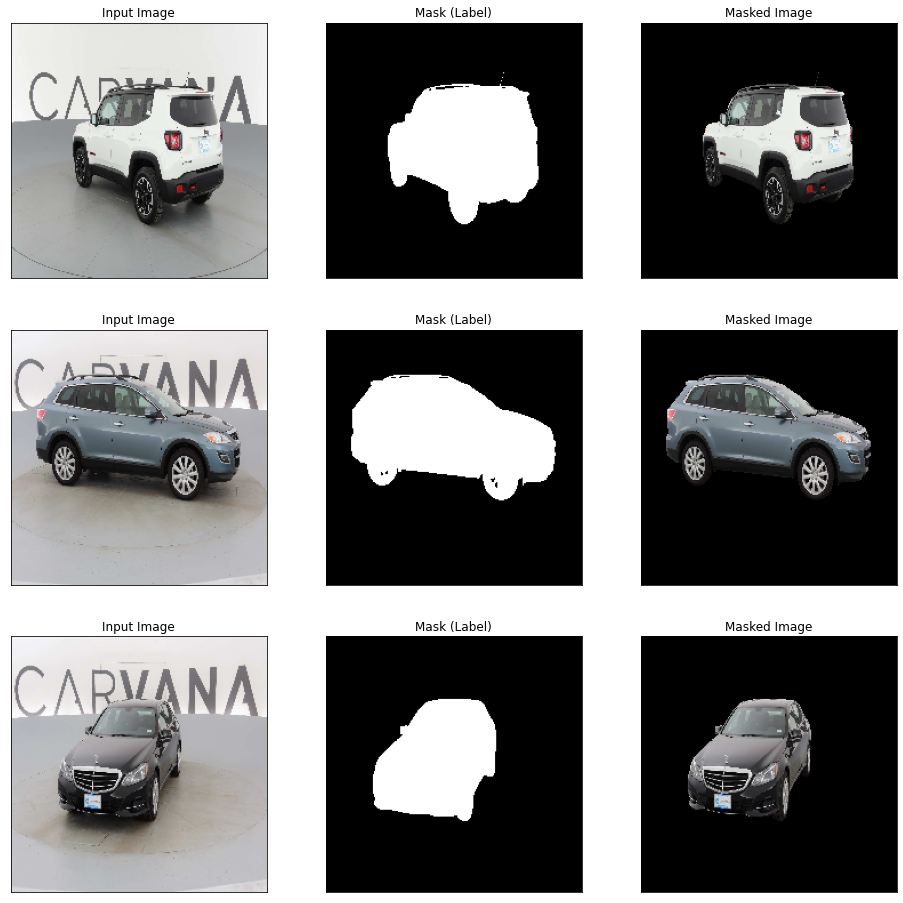

In [0]:
# Display a few images and their masks from the training set
sample_inds = [7, 103, 458]

n_rows = len(sample_inds)
n_cols = 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 16))

for i, sample_index in enumerate(sample_inds):
  img = X_train[sample_index].astype(np.uint8)
  mask = y_train[sample_index].astype(np.uint8)[:,:,0]
  masked_img = np.array(img, copy=True)
  masked_img[np.where(mask == 0)] = 0

  ax[i,0].imshow(img)
  ax[i,0].set_title('Input Image')
  ax[i,1].imshow(mask, cmap='gray')
  ax[i,1].set_title('Mask (Label)')
  ax[i,2].imshow(masked_img)
  ax[i,2].set_title('Masked Image')

  for j in range(n_cols):
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

plt.show()

___
## U-Net Implementation

The U-Net architecture I will be using in this notebook is inspired by [TernausNet](https://arxiv.org/abs/1801.05746), a U-Net that uses a pretrained VGG-11 encoder.  This network actually won the Carvana Image Segmentation problem.

The Keras model implemented below is a U-Net which is composed of a pre-trained VGG-16 encoder and a corresponding decoder to reconstruct the image mask from the latent feature tensors of the VGG-16 encoder.  Keras offers a pre-trained VGG-16 model (trained on the imagenet dataset) as an off-the-shelf model.

In [0]:
# Load the encoder, a pretrained VGG-16 network and remove its final pooling layer
img_input = Input(shape=(224, 224, 3))
model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=img_input, pooling='max')
model.layers.pop()

In [0]:
print('VGG-16 Encoder Summary:')
print(model.summary())

VGG-16 Encoder Summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 5

The encoder outputs that are later concatenated with the approprate decoder tensor outputs are located at indices 2, 5, 9, 13, and 17 of the VGG-16 encoder.  These are the layers that occur before each Max Pooling layer.

In [0]:
# Create center layer to connect encoder to decoder
center = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(model.layers[-1].output)

# Apply transpose convolution, concatenate layer 17's outputs and then convolve again
decode = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(center)
decode = Concatenate(axis=-1)([decode, model.layers[17].output])
decode = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(decode)

# Apply transpose convolution, concatenate layer 13's outputs and then convolve again
decode = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(decode)
decode = Concatenate(axis=-1)([decode, model.layers[13].output])
decode = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(decode)

# Apply transpose convolution, concatenate layer 19's outputs and then convolve again
decode = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(decode)
decode = Concatenate(axis=-1)([decode, model.layers[9].output])
decode = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(decode)

# Apply transpose convolution, concatenate layer 15's outputs and then convolve again
decode = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(decode)
decode = Concatenate(axis=-1)([decode, model.layers[5].output])
decode = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(decode)

# Apply transpose convolution, concatenate layer 12's outputs and then convolve again.
# This time, use a sigmoid activate after the last convolution so that the output tensor
# will be a 224x224 pixel tensor with values between 0 and 1.
decode = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(decode)
decode = Concatenate(axis=-1)([decode, model.layers[2].output])
output = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(decode)

# Combine encoder and decoder layers
unet = Model(input=model.input, output=output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
print('U-Net Architecture Summary:')
unet.summary()

U-Net Architecture Summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
________________________________________________________________

___
## Train the U-Net and Inspect Resulting Masks

In [0]:
# Process the input images in accordance with the pre-trained VGG-16
# processing specifications.
X_train_processed = preprocess_input(np.array(X_train, copy=True))
X_valid_processed = preprocess_input(np.array(X_valid, copy=True))
X_test_processed = preprocess_input(np.array(X_test, copy=True))

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)
unet.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
unet.fit(X_train_processed, y_train, validation_data=(X_valid_processed, y_valid), epochs=100, callbacks=[early_stopping], batch_size=64)

Train on 768 samples, validate on 128 samples
Epoch 1/100
768/768 [==============================] - 17s 22ms/step - loss: 30.7291 - val_loss: 10.5430
Epoch 2/100
768/768 [==============================] - 11s 14ms/step - loss: 6.2815 - val_loss: 3.5572
Epoch 3/100
768/768 [==============================] - 11s 14ms/step - loss: 4.6729 - val_loss: 6.2791
Epoch 4/100
768/768 [==============================] - 11s 14ms/step - loss: 3.5470 - val_loss: 2.0254
Epoch 5/100
768/768 [==============================] - 11s 14ms/step - loss: 1.6249 - val_loss: 1.1425
Epoch 6/100
768/768 [==============================] - 11s 14ms/step - loss: 0.9878 - val_loss: 0.9286
Epoch 7/100
768/768 [==============================] - 11s 14ms/step - loss: 0.7173 - val_loss: 0.5710
Epoch 8/100
768/768 [==============================] - 11s 14ms/step - loss: 0.5679 - val_loss: 0.5030
Epoch 9/100
768/768 [==============================] - 11s 14ms/step - loss: 0.4886 - val_loss: 0.4058
Epoch 10/100
768/768 [===

In [0]:
#unet.save('/content/drive/My Drive/EEG GAN/carvana data/caravana_numpy_arrays/carvana_unet.h5')
#unet = load_model('/content/drive/My Drive/EEG GAN/carvana data/caravana_numpy_arrays/carvana_unet.h5')

In [0]:
test_predictions = unet.predict(X_test_processed)

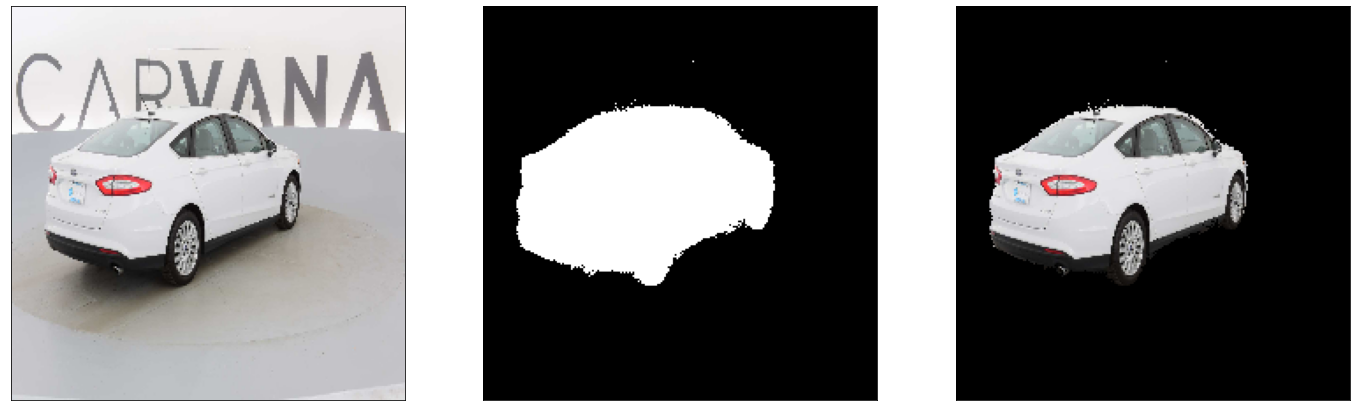

In [0]:
index = 111

img = X_test[index].astype(np.uint8)

masked_img = np.array(img, copy=True)
masked_img[np.where(test_predictions[index][:,:,0] < 0.5)] = 0

fig, ax = plt.subplots(1,3,figsize=(24, 10))
ax[0].imshow(img)
ax[1].imshow(test_predictions[index][:,:,0] > 0.5, cmap='gray')
ax[2].imshow(masked_img)

for axis in ax:
  axis.set_xticks([])
  axis.set_yticks([])

plt.show()

## References
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038)
- [Review: FCN — Fully Convolutional Network (Semantic Segmentation)](https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1)
- [Semantic Segmentation using Fully Convolutional Neural Networks](https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b)
- [Transposed Convolution Demystified](https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba)
- [TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation](https://arxiv.org/abs/1801.05746)
- [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge)